In [291]:
import sys
sys.path.append('..')

import numpy as np
import cirq
import mitiq
from cirq.contrib.qasm_import import circuit_from_qasm
import matplotlib.pyplot as plt
from functools import partial
from tqdm import tqdm
import sympy as sp


import daqec



**construct the ideal circuit**

In [184]:
qubits = cirq.LineQubit.range(2)
circ = cirq.Circuit([
    cirq.H(qubits[0]),
    cirq.H(qubits[1]),
    cirq.CNOT(qubits[0], qubits[1]),
    cirq.X.on(qubits[0]),
    cirq.T.on(qubits[1]),
    cirq.CNOT(qubits[1], qubits[0]),
    cirq.ZPowGate(exponent=0.1).on(qubits[0]),
    cirq.S.on(qubits[1]),
    cirq.CNOT(qubits[0], qubits[1]),
    cirq.XPowGate(exponent=0.1).on(qubits[0]),
    cirq.H.on(qubits[1]),
    cirq.CNOT(qubits[1], qubits[0]),
])
# circ = cirq.Circuit([  # only involves 2-qubit gates
#     cirq.XXPowGate(exponent=0.1).on(qubits[0], qubits[1]),
#     cirq.Rz(rads=0.2).on(qubits[1]).controlled_by(qubits[0]),
#     cirq.YYPowGate(exponent=0.1).on(qubits[0], qubits[1]),
#     cirq.Rx(rads=0.1).on(qubits[0]).controlled_by(qubits[1]),
#     cirq.ZZPowGate(exponent=0.1).on(qubits[0], qubits[1]),
# ])
circ

0: ───H───@───X───X───Z^0.1───@───X^0.1───X───
          │       │           │           │
1: ───H───X───T───@───S───────X───H───────@───

In [185]:
init_state = np.array([
    [1, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
]).astype(complex)
final_state = circ.unitary() @ init_state @ circ.unitary().conj().T
prob_11 = final_state[1, 1].real
prob_11

0.46753024329587667

In [186]:
final_state.round(3)

array([[ 0.08 +0.j   , -0.109-0.16j ,  0.07 -0.022j,  0.052+0.168j],
       [-0.109+0.16j ,  0.468+0.j   , -0.052+0.168j, -0.406-0.125j],
       [ 0.07 +0.022j, -0.052-0.168j,  0.066+0.j   ,  0.   +0.16j ],
       [ 0.052-0.168j, -0.406+0.125j,  0.   -0.16j ,  0.386+0.j   ]])

In [187]:
n = len(qubits)
p_cirq = 0.01
p = 4**n / (4**n - 1) * p_cirq
print(f'p_cirq = {p_cirq}, p = {p}')

p_cirq = 0.01, p = 0.010666666666666666


In [190]:
circ_noise_interleaved = cirq.Circuit()
for g in circ.all_operations():
    circ_noise_interleaved.append(g)
    circ_noise_interleaved.append(cirq.depolarize(p_cirq, 2).on(*qubits))
circ_noise_interleaved

0: ───H───D(0.01)───────D(0.01)───@───D(0.01)───X───D(0.01)───────D(0.01)───X───D(0.01)───Z^0.1───D(0.01)───────D(0.01)───@───D(0.01)───X^0.1───D(0.01)───────D(0.01)───X───D(0.01)───
          │             │         │   │             │             │         │   │                 │             │         │   │                 │             │         │   │
1: ───────#2────────H───#2────────X───#2────────────#2────────T───#2────────@───#2────────────────#2────────S───#2────────X───#2────────────────#2────────H───#2────────@───#2────────

In [192]:
r = daqec.circuits.num_gates(circ)
p_r = 1 - (1 - p)**r
p_r_cirq = p_r * (4**n - 1) / 4**n
print(f'p_r_cirq = {p_r_cirq}, p = {p_r}')
circ_noise = circ.copy()
circ_noise.append(cirq.depolarize(p_r_cirq, 2).on(*qubits))
circ_noise

p_r_cirq = 0.11320440490756703, p = 0.12075136523473817


0: ───H───@───X───X───Z^0.1───@───X^0.1───X───D(0.113)───
          │       │           │           │   │
1: ───H───X───T───@───S───────X───H───────@───#2─────────

**noisy simulation comparison**

In [193]:
sim = cirq.DensityMatrixSimulator()

rho1 = sim.simulate(circ_noise_interleaved).final_density_matrix
rho2 = sim.simulate(circ_noise).final_density_matrix

assert np.allclose(rho1, rho2, atol=1e-5), "rho1 and rho2 should be equal!"

**append inverse channel to `circ_noise`**

In [194]:
circ_noise

0: ───H───@───X───X───Z^0.1───@───X^0.1───X───D(0.113)───
          │       │           │           │   │
1: ───H───X───T───@───S───────X───H───────@───#2─────────

In [195]:
final_state_noise = cirq.DensityMatrixSimulator().simulate(circ_noise).final_density_matrix
prob_11_noise = final_state_noise[1, 1].real
print('disparity = ', prob_11_noise - prob_11)

disparity =  -0.02626713385030477


**Testing our error mitigation approach**:

- baseline: conventional PEC method
- baseline: linear combination of two noisy channels: $\mathcal{E}^{-1} = \eta_1\mathcal{E}_1 - \eta_2\mathcal{E}_2$ in which both $\mathcal{E}_1$ and $\mathcal{E}_2$ are depolarizing channels (CPTP)
- our end-to-end PEC method: ...

In [196]:
# baseline: conventional PEC

# def execute(circ: cirq.Circuit):
#     return cirq.DensityMatrixSimulator().simulate(circ).final_density_matrix[1,1].real

def execute_noisy(circ: cirq.Circuit, p_cirq):
    n = cirq.num_qubits(circ)
    p = 4**n / (4**n - 1) * p_cirq
    p_r = 1 - (1 - p)**r
    p_r_cirq = p_r * (4**n - 1) / 4**n
    qubits = list(circ.all_qubits())
    circ_noise = circ.copy()
    circ_noise.append(cirq.depolarize(p_r_cirq, 2).on(*qubits))
    return cirq.DensityMatrixSimulator().simulate(circ_noise).final_density_matrix[1,1].real

def execute_noise_interleaved(circ: cirq.Circuit, p_cirq):
    circ_noise_interleaved = cirq.Circuit()
    for moment in circ:
        circ_noise_interleaved.append(moment)
        circ_noise_interleaved.append(cirq.depolarize(p_cirq, 2).on(*qubits))
    return cirq.DensityMatrixSimulator().simulate(circ_noise_interleaved).final_density_matrix[1,1].real


In [215]:
rates_cirq = np.linspace(0, 0.1, 11)
noisy_vals = [execute_noisy(circ, p_cirq) for p_cirq in rates_cirq]

In [202]:
reps = mitiq.pec.represent_operations_in_circuit_with_global_depolarizing_noise(circ, p)
mitiq.pec.execute_with_pec(circ, partial(execute_noisy, p_cirq=p_cirq), representations=reps, random_state=42)

baseline: conventional PEC method

In [211]:
pec_vals = []

for p_cirq in tqdm(rates_cirq):
    reps = mitiq.pec.represent_operations_in_circuit_with_global_depolarizing_noise(circ, p_cirq)
    pec_vals.append(mitiq.pec.execute_with_pec(circ, partial(execute_noisy, p_cirq=p_cirq), 
                                                  representations=reps, random_state=42))

 91%|█████████ | 10/11 [16:25<03:28, 208.40s/it]/Users/jack/opt/miniconda3/lib/python3.8/site-packages/mitiq/pec/pec.py:123: LargeSampleWarning: The number of PEC samples is very large. It may take several minutes. It may be necessary to reduce 'precision' or 'num_samples'.
  warnings.warn(_LARGE_SAMPLE_WARN, LargeSampleWarning)
100%|██████████| 11/11 [27:07<00:00, 147.91s/it]


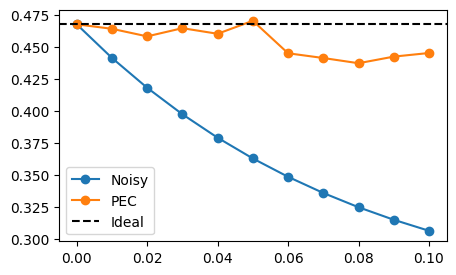

In [214]:
plt.figure(figsize=(5, 3))
plt.plot(rates_cirq, noisy_vals, 'o-', label='Noisy')
plt.plot(rates_cirq, pec_vals, 'o-', label='PEC')
plt.axhline(prob_11, color='k', linestyle='--', label='Ideal')
plt.legend()
plt.show()

In [150]:
# def execute_local_depolarizing(circ: cirq.Circuit, p_cirq):
#     circ_local_noise = circ.copy()
#     circ_local_noise = circ_local_noise.with_noise(cirq.depolarize(p_cirq))
#     return cirq.DensityMatrixSimulator().simulate(circ_local_noise).final_density_matrix[1,1].real

# noisy_vals = [execute_local_depolarizing(circ, p_cirq) for p_cirq in rates_cirq[:6]]

# pec_vals = []

# for p_cirq in tqdm(rates_cirq):
#     p = 4**n / (4**n - 1) * p_cirq
#     reps = mitiq.pec.represent_operations_in_circuit_with_local_depolarizing_noise(circ, p)
#     pec_vals.append(mitiq.pec.execute_with_pec(circ, 
#                                                partial(execute_local_depolarizing, p_cirq=p_cirq), 
#                                                representations=reps, random_state=42))


baseline: linear combination of two noisy channels: $\mathcal{E}^{-1} = \eta_1\mathcal{E}_1 - \eta_2\mathcal{E}_2$ in which both $\mathcal{E}_1$ and $\mathcal{E}_2$ are depolarizing channels (CPTP)

In [230]:
def inv_channel_rate(epsilon, n=1):
    return (4**n-1) * epsilon / (4**n-1 - 4**n * epsilon)

def decompose_inv_channel(eta_1, epsilon_inv):
    """
    The result is a relationship between epsilon_1 and epsilon_2 for subsequent manual settings for their specific values.
    """
    import sympy as sp
    # 定义未知数
    epsilon_1, epsilon_2 = sp.symbols('epsilon_1 epsilon_2')

    # 已知常数
    eta_2 = eta_1 - 1  # 例如

    # 定义方程
    eq1 = sp.Eq(eta_1 * (1 - epsilon_1) - eta_2 * (1 - epsilon_2), 1 + epsilon_inv)
    eq2 = sp.Eq(eta_1 * epsilon_1 + epsilon_inv, eta_2 * epsilon_2)

    # 求解方程组
    solutions = sp.solve((eq1, eq2), (epsilon_1, epsilon_2))

    return solutions

In [264]:
decompose_inv_channel(2, round(inv_channel_rate(p_r_cirq, 2), 7))

{epsilon_1: 0.5*epsilon_2 - 0.06437565}

In [275]:
eta_1 = 2
eta_2 = eta_1 - 1

epsilon_1 = sp.symbols('epsilon_1')
epsilon_2 = sp.symbols('epsilon_2')
sol = decompose_inv_channel(eta_1, round(inv_channel_rate(p_r_cirq, 2), 7))
sol

{epsilon_1: 0.5*epsilon_2 - 0.06437565}

In [276]:
prob_11, prob_11_noise

(0.46753024329587667, 0.4412631)

In [277]:
p2 = 0.4
p1 = float(sol[epsilon_1].subs(epsilon_2, p2))
print(f"p1 = {p1}, p2 = {p2}")

p1 = 0.13562435, p2 = 0.4


In [290]:
# verify the correctness of (eta_1, eta_2, p1, p2) -> K_inv
channel = cirq.depolarize(p_r_cirq, 2)
super_opr = cirq.kraus_to_superoperator(cirq.protocols.kraus_protocol.kraus(channel))
super_opr_inv = np.linalg.inv(super_opr)

super_opr_1 = cirq.kraus_to_superoperator(cirq.protocols.kraus_protocol.kraus(cirq.depolarize(p1, 2)))
super_opr_2 = cirq.kraus_to_superoperator(cirq.protocols.kraus_protocol.kraus(cirq.depolarize(p2, 2)))

K_inv = (eta_1 * super_opr_1 - eta_2 * super_opr_2)

assert np.allclose(super_opr_inv, K_inv)

In [293]:
# let's do linear combination of the effect of inverse channel
circ_noise

0: ───H───@───X───X───Z^0.1───@───X^0.1───X───D(0.113)───
          │       │           │           │   │
1: ───H───X───T───@───S───────X───H───────@───#2─────────

In [298]:
circ_noise_1 = circ_noise.copy()
circ_noise_2 = circ_noise.copy()
circ_noise_1.append(cirq.depolarize(p1, 2).on(*qubits))
circ_noise_2.append(cirq.depolarize(p2, 2).on(*qubits))

In [299]:
res1 = cirq.DensityMatrixSimulator().simulate(circ_noise_1).final_density_matrix[1,1].real
res2 = cirq.DensityMatrixSimulator().simulate(circ_noise_2).final_density_matrix[1,1].real
res1, res2

(0.4135938, 0.35965756)

In [301]:
res = eta_1 * res1 - eta_2 * res2
print(prob_11, prob_11_noise, res)
print('disparity = ', res - prob_11)

0.46753024329587667 0.4412631 0.4675300419330597
disparity =  -2.0136281697613612e-07


our end-to-end PEC method: 